# Only 2023

## Importation

In [74]:
import os
import uuid
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

## dl

In [171]:
def get_csv(url,download_folder) : 
    response = requests.get(url)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    csv_links = soup.find_all('a', href=True)
    csv_links = [link for link in csv_links if link['href'].endswith('.csv')]
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
              
    for link in csv_links:
        file_url = urljoin(url, link['href'])
        original_file_name = os.path.basename(link['href'])
        unique_file_name = f"{uuid.uuid4()}_{original_file_name}"
        file_path = os.path.join(download_folder, unique_file_name)
        
        try :    
            file_response = requests.get(file_url)
            file_response.raise_for_status()
    
            with open(file_path, 'wb') as file:
                file.write(file_response.content)
        except requests.exceptions.RequestException as e:
            print(f'Error downloading {unique_file_name}:{e}')
    
    print(f'Download completed for URL:{url}')   

In [173]:
url = 'https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/'

In [175]:
download_folder = r'C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\PortfolioData\House_Price_Toulouse\CSV'

In [177]:
 get_csv(url, download_folder)

Download completed for URL:https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/


## concate in one file 

In [180]:
dfs = []
for file_name in os.listdir(download_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(download_folder, file_name)
        # Lire chaque fichier CSV et l'ajouter à la liste des DataFrames
        df = pd.read_csv(file_path)
        dfs.append(df)
        
concatenated_df = pd.concat(dfs, ignore_index=True)
output_file = os.path.join(download_folder, 'concatenated.csv')
concatenated_df.to_csv(output_file, index=False)

print(f'All CSV files have been concatenated into : {output_file}')

All CSV files have been concatenated into : C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\PortfolioData\House_Price_Toulouse\CSV\concatenated.csv


## read csv

In [182]:
df = pd.read_csv(os.path.join(download_folder, 'concatenated.csv'))
df.head(3)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2023-387083,2023-03-01,1,Vente,1500.0,NaN,NaN,LA VIELLE NORD,B074,31160.0,...,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,2085.0,0.815090,43.049855
1,2023-387083,2023-03-01,1,Vente,1500.0,NaN,NaN,LA VIELLE NORD,B074,31160.0,...,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,335.0,0.815872,43.049821
2,2023-387083,2023-03-01,1,Vente,1500.0,NaN,NaN,LA VIELLE NORD,B074,31160.0,...,NaN,NaN,NaN,P,prés,NaN,NaN,503.0,0.816232,43.049082


In [184]:
len(df)

73135

## cleaning

### lines : keep only House and Appartment, drop the duplicate

In [187]:
df = df[(df.type_local=="Maison")|(df.type_local=="Appartement")].reset_index()

In [189]:
df = df[df.nature_mutation=='Vente']

In [191]:
df = df.drop_duplicates(subset=['id_mutation'])

In [193]:
len(df)

18786

### columns : drop

In [195]:
df = df[['valeur_fonciere','code_postal','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain']]

In [197]:
df = df.reset_index(drop=True)

## code postale

In [199]:
df['code_postal'] = df['code_postal'].apply(str)
df['code_postal'] = df['code_postal'].str.split('.').str[0]

## Missing data

In [201]:
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()
    
    return per_nan

In [203]:
per_nan = percent_missing(df)
per_nan

valeur_fonciere     0.058554
nature_culture     56.350474
surface_terrain    56.350474
dtype: float64

In [205]:
df = df.dropna(subset=['valeur_fonciere'])

In [207]:
df['nature_culture'] = df['nature_culture'].fillna('None')
df['surface_terrain'] = df['surface_terrain'].fillna(0)

In [209]:
per_nan = percent_missing(df)
per_nan

Series([], dtype: float64)

## Save the clean data, separated House and Apartement (Appt)

In [211]:
df.to_csv("HouseApptPrice_Tls_2023.csv",index=False)

In [3]:
df = pd.read_csv("HouseApptPrice_Tls_2023.csv")

In [5]:
df_maison = df[df['type_local']=='Maison']
df_appt = df[df['type_local']=='Appartement']

In [7]:
df_maison.to_csv("HousePrice_Tls_2023.csv",index=False)
df_appt.to_csv("ApptPrice_Tls_2023.csv",index=False)

In [9]:
len(df_maison)

8484

In [11]:
len(df_appt)

10291

## Outliers

### Analysis

In [13]:
df_house = pd.read_csv("HousePrice_Tls_2023.csv")

In [15]:
df_house['prix_mcarre'] = df_house['valeur_fonciere']/df_house['surface_reelle_bati']

In [17]:
df_house['valeur_fonciere'].describe()

count    8.484000e+03
mean     3.117134e+05
std      2.314564e+05
min      1.000000e+00
25%      1.928750e+05
50%      2.760000e+05
75%      3.755000e+05
max      6.000146e+06
Name: valeur_fonciere, dtype: float64

In [19]:
df_house['prix_mcarre'].describe()

count     8484.000000
mean      3013.771571
std       2383.828591
min          0.006452
25%       2074.663210
50%       2857.142857
75%       3531.002183
max      76666.666667
Name: prix_mcarre, dtype: float64

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


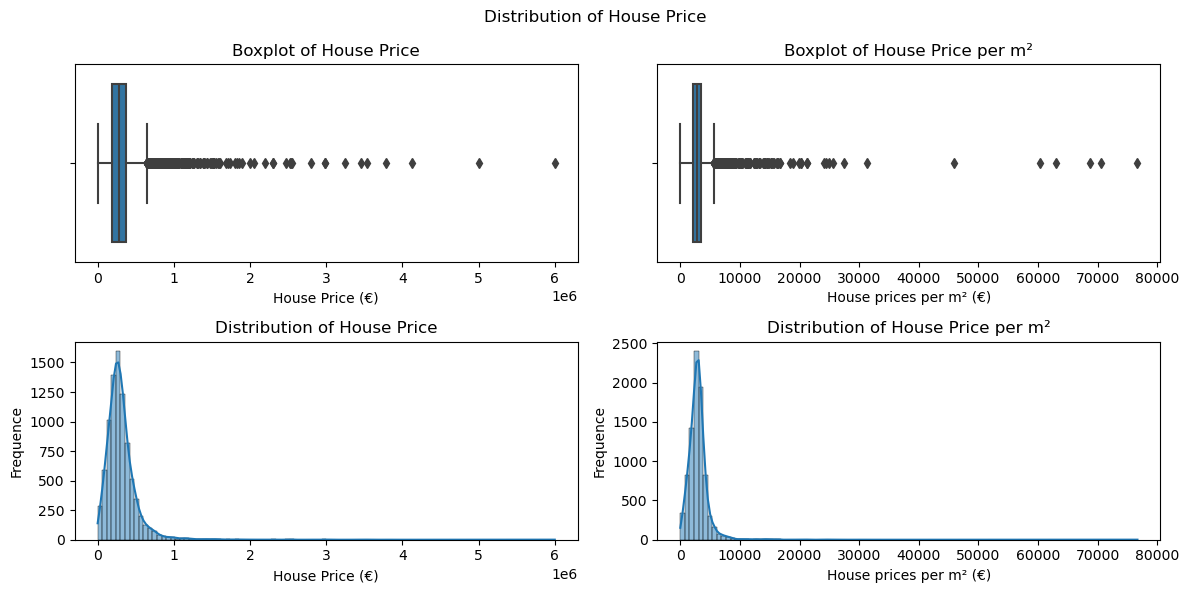

In [21]:
fig, axes = plt.subplots(2,2,figsize=(12, 6))

sns.boxplot(x=df_house['valeur_fonciere'], ax=axes[0][0])
axes[0][0].set_xlabel('House Price (€)')
axes[0][0].set_title('Boxplot of House Price')


sns.boxplot(x=df_house['prix_mcarre'], ax=axes[0][1])
axes[0][1].set_xlabel('House prices per m² (€)')
axes[0][1].set_title('Boxplot of House Price per m²')


sns.histplot(df_house['valeur_fonciere'], bins=100, kde=True,ax=axes[1][0])
axes[1][0].set_xlabel('House Price (€)')
axes[1][0].set_ylabel('Frequence')
axes[1][0].set_title('Distribution of House Price')


sns.histplot(df_house['prix_mcarre'], bins=100, kde=True,ax=axes[1][1])
axes[1][1].set_xlabel('House prices per m² (€)')
axes[1][1].set_ylabel('Frequence')
axes[1][1].set_title('Distribution of House Price per m²')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

### Sup

In [23]:
def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    outliers=df[((df<(q1-1.5*IQR)) | (df>(q3 + 1.5*IQR)))]
    return outliers 

In [25]:
outliers_valeur_fonciere = pd.DataFrame(find_outliers(df_house['valeur_fonciere']))
outliers_prix_mcarre = pd.DataFrame(find_outliers(df_house['prix_mcarre']))

In [27]:
index_outliers_valeur_fonciere = outliers_valeur_fonciere.index
index_outliers_prix_mcarre = outliers_prix_mcarre.index

In [29]:
drop_indices = index_outliers_valeur_fonciere.union(index_outliers_prix_mcarre)

In [31]:
len(drop_indices)

570

In [33]:
100*len(drop_indices)/len(df_house)

6.718528995756719

In [35]:
df_house_cleaned = df_house.drop(index=drop_indices)

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


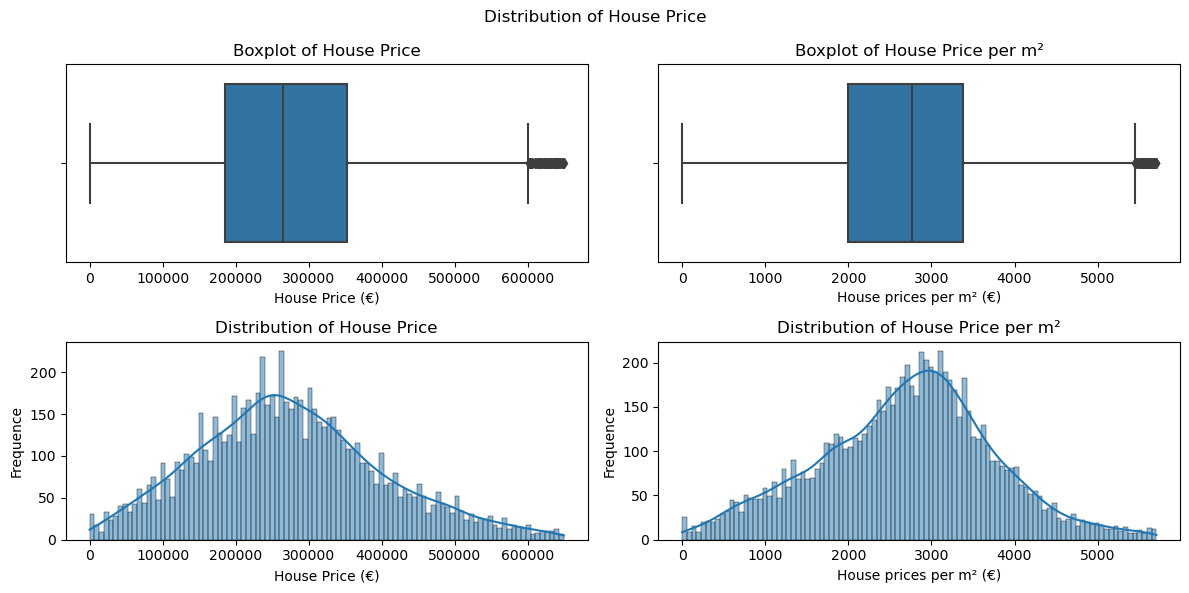

In [37]:
fig, axes = plt.subplots(2,2,figsize=(12, 6))

sns.boxplot(x=df_house_cleaned['valeur_fonciere'], ax=axes[0][0])
axes[0][0].set_xlabel('House Price (€)')
axes[0][0].set_title('Boxplot of House Price')


sns.boxplot(x=df_house_cleaned['prix_mcarre'], ax=axes[0][1])
axes[0][1].set_xlabel('House prices per m² (€)')
axes[0][1].set_title('Boxplot of House Price per m²')


sns.histplot(df_house_cleaned['valeur_fonciere'], bins=100, kde=True,ax=axes[1][0])
axes[1][0].set_xlabel('House Price (€)')
axes[1][0].set_ylabel('Frequence')
axes[1][0].set_title('Distribution of House Price')


sns.histplot(df_house_cleaned['prix_mcarre'], bins=100, kde=True,ax=axes[1][1])
axes[1][1].set_xlabel('House prices per m² (€)')
axes[1][1].set_ylabel('Frequence')
axes[1][1].set_title('Distribution of House Price per m²')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

### inf

In [39]:
count_below_10000 = len(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000])
print(f"Nombre de ventes inférieures à 10 000 €: {count_below_10000}")

Nombre de ventes inférieures à 10 000 €: 34


C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


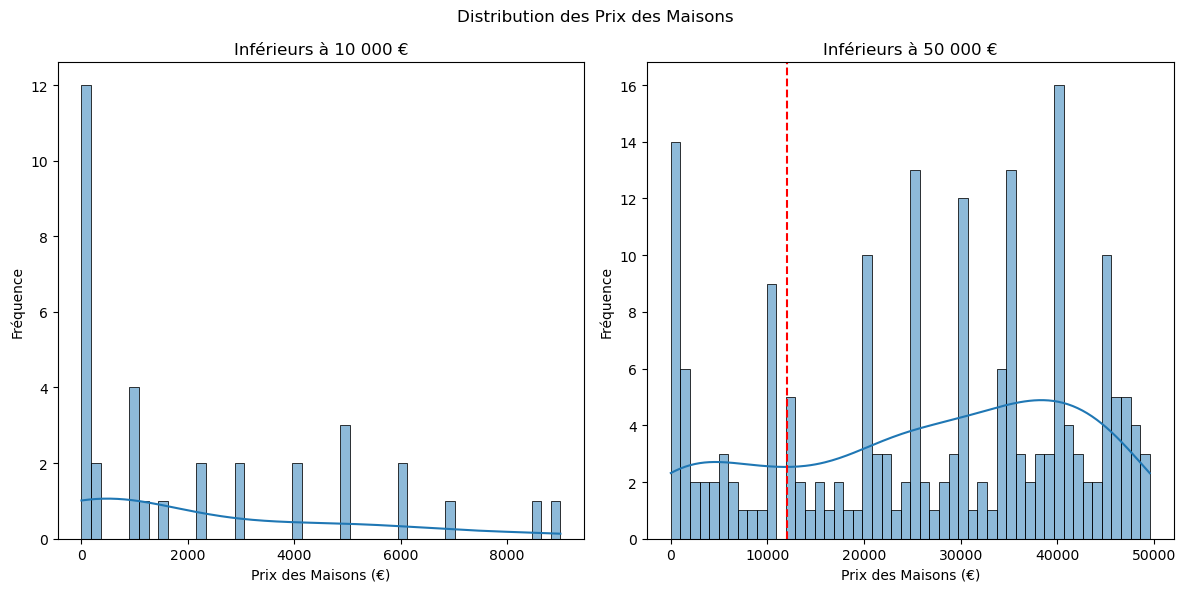

In [41]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))

sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000]['valeur_fonciere'], bins=50, kde=True,ax=axes[0])
sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 50000]['valeur_fonciere'], bins=50, kde=True,ax=axes[1])

for axe in axes.flat :
    axe.set(xlabel='Prix des Maisons (€)',ylabel='Fréquence')
    axe.set_ylabel('Fréquence')

fig.suptitle('Distribution des Prix des Maisons')  

axes[0].set_title('Inférieurs à 10 000 €')
axes[1].set_title('Inférieurs à 50 000 €')
axes[1].axvline(x=12000,color='red',linestyle='--')
  
plt.tight_layout()

In [43]:
df_house_cleaned[df_house_cleaned['prix_mcarre'] < 500]['prix_mcarre'].describe()

count    160.000000
mean     263.605220
std      157.342044
min        0.006452
25%      139.375000
50%      286.662453
75%      399.442799
max      493.827160
Name: prix_mcarre, dtype: float64

In [45]:
df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000]['prix_mcarre'].describe()

count     34.000000
mean      33.152223
std       43.665217
min        0.006452
25%        0.013926
50%       14.636752
75%       46.993671
max      150.000000
Name: prix_mcarre, dtype: float64

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


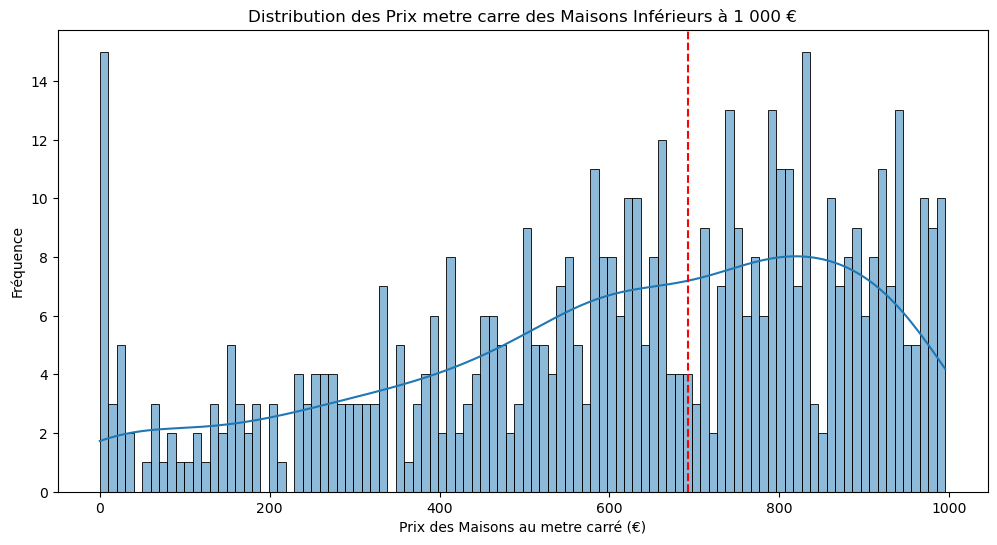

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(df_house_cleaned[df_house_cleaned['prix_mcarre'] < 1000]['prix_mcarre'], bins=100, kde=True)
plt.title('Distribution des Prix metre carre des Maisons Inférieurs à 1 000 €')
plt.xlabel('Prix des Maisons au metre carré (€)')
plt.ylabel('Fréquence')
plt.axvline(x=692,color='red',linestyle='--')
plt.show()

In [49]:
df_house_cleaned = df_house_cleaned[df_house_cleaned['valeur_fonciere'] > 10000]

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


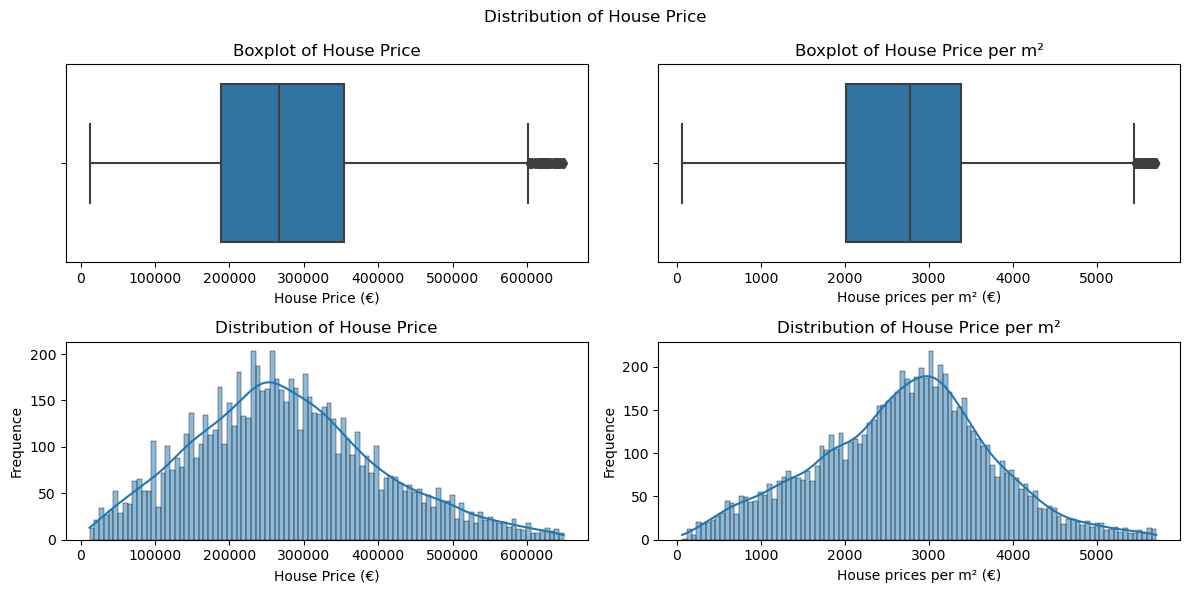

In [51]:
fig, axes = plt.subplots(2,2,figsize=(12, 6))

sns.boxplot(x=df_house_cleaned['valeur_fonciere'], ax=axes[0][0])
axes[0][0].set_xlabel('House Price (€)')
axes[0][0].set_title('Boxplot of House Price')


sns.boxplot(x=df_house_cleaned['prix_mcarre'], ax=axes[0][1])
axes[0][1].set_xlabel('House prices per m² (€)')
axes[0][1].set_title('Boxplot of House Price per m²')


sns.histplot(df_house_cleaned['valeur_fonciere'], bins=100, kde=True,ax=axes[1][0])
axes[1][0].set_xlabel('House Price (€)')
axes[1][0].set_ylabel('Frequence')
axes[1][0].set_title('Distribution of House Price')


sns.histplot(df_house_cleaned['prix_mcarre'], bins=100, kde=True,ax=axes[1][1])
axes[1][1].set_xlabel('House prices per m² (€)')
axes[1][1].set_ylabel('Frequence')
axes[1][1].set_title('Distribution of House Price per m²')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

### others columns

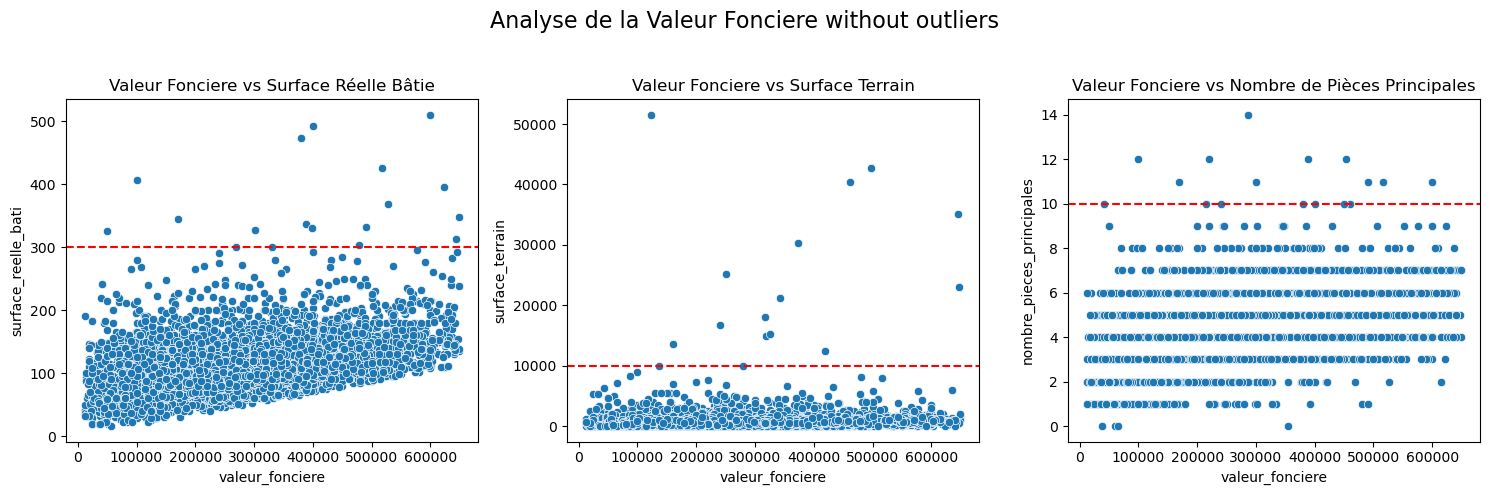

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_reelle_bati', ax=axes[0])
axes[0].set_title('Valeur Fonciere vs Surface Réelle Bâtie')
axes[0].axhline(y=300,color='red', linestyle='--')

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_terrain', ax=axes[1])
axes[1].set_title('Valeur Fonciere vs Surface Terrain')
axes[1].axhline(y=10000,color='red', linestyle='--')

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='nombre_pieces_principales', ax=axes[2])
axes[2].set_title('Valeur Fonciere vs Nombre de Pièces Principales')
axes[2].axhline(y=10,color='red', linestyle='--')

fig.suptitle('Analyse de la Valeur Fonciere without outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [55]:
drop_ind_bati = df_house_cleaned[(df_house_cleaned['surface_reelle_bati']>300)].index
drop_ind_terrain = df_house_cleaned[(df_house_cleaned['surface_terrain']>10000)].index
drop_ind_piece = df_house_cleaned[(df_house_cleaned['nombre_pieces_principales']>10)].index

drop_indices = drop_ind_bati.union(drop_ind_terrain).union(drop_ind_piece)

df_house_cleaned = df_house_cleaned.drop(drop_indices,axis=0)

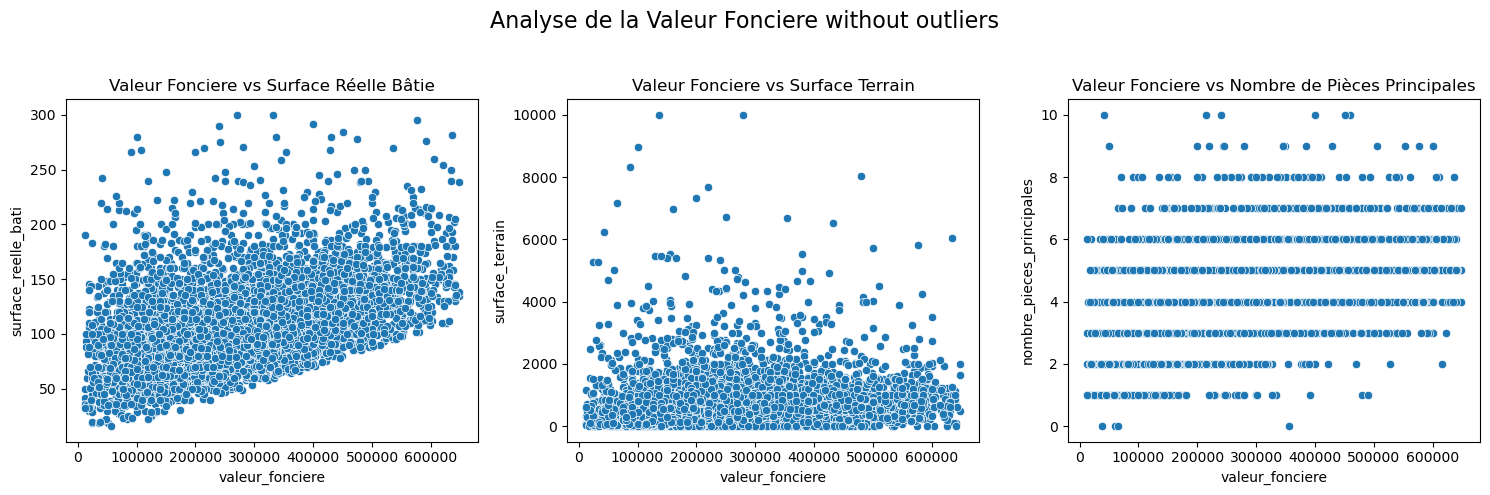

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_reelle_bati', ax=axes[0])
axes[0].set_title('Valeur Fonciere vs Surface Réelle Bâtie')


sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_terrain', ax=axes[1])
axes[1].set_title('Valeur Fonciere vs Surface Terrain')


sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='nombre_pieces_principales', ax=axes[2])
axes[2].set_title('Valeur Fonciere vs Nombre de Pièces Principales')


fig.suptitle('Analyse de la Valeur Fonciere without outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [59]:
df_house_cleaned = df_house_cleaned.reset_index(drop=True)

In [61]:
df_house_cleaned.to_csv('HousePrice_Tls_2023_cleaned.csv',index=False)

## EDA

In [63]:
df_house_cleaned = pd.read_csv('HousePrice_Tls_2023_cleaned.csv')

In [65]:
df_house_cleaned['valeur_fonciere'].describe()

count      7836.000000
mean     275916.373444
std      125335.466730
min       12000.000000
25%      188000.000000
50%      265900.000000
75%      352237.500000
max      648300.000000
Name: valeur_fonciere, dtype: float64

In [67]:
df_house_cleaned.corr(numeric_only = True)['valeur_fonciere'].sort_values()

code_postal                  0.043585
surface_terrain              0.150050
nombre_pieces_principales    0.427802
surface_reelle_bati          0.481969
prix_mcarre                  0.728127
valeur_fonciere              1.000000
Name: valeur_fonciere, dtype: float64

In [69]:
corr = df_house_cleaned.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,surface_terrain,prix_mcarre
valeur_fonciere,1.000000,0.043585,0.481969,0.427802,0.150050,0.728127
code_postal,0.043585,1.000000,0.030112,0.024443,0.043509,0.021042
surface_reelle_bati,0.481969,0.030112,1.000000,0.665616,0.289465,-0.174384
nombre_pieces_principales,0.427802,0.024443,0.665616,1.000000,0.136715,-0.007134
surface_terrain,0.150050,0.043509,0.289465,0.136715,1.000000,-0.047663
prix_mcarre,0.728127,0.021042,-0.174384,-0.007134,-0.047663,1.000000


In [79]:
df_house_31600 = df_house_cleaned[df_house_cleaned['code_postal'] == 31600]

In [81]:
stats.linregress(df_house_31600['valeur_fonciere'],df_house_31600['surface_reelle_bati'])

LinregressResult(slope=0.00019911214309637995, intercept=50.249942784922176, rvalue=0.6287122271304431, pvalue=1.158385435008802e-41, stderr=1.2908407009973446e-05, intercept_stderr=3.812104767312706)

<Axes: xlabel='valeur_fonciere', ylabel='surface_reelle_bati'>

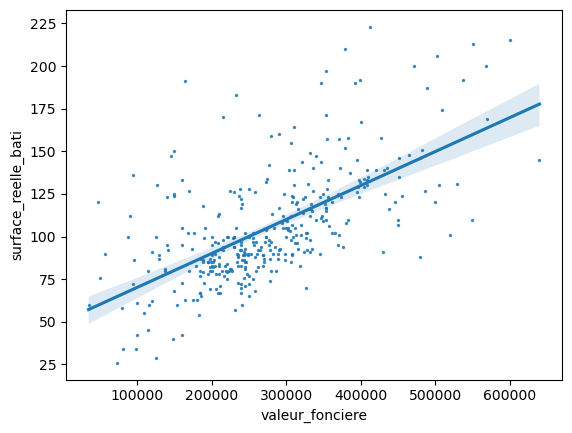

In [83]:
sns.regplot(x=df_house_31600['valeur_fonciere'], y=df_house_31600['surface_reelle_bati'],scatter_kws={'s':2})

In [85]:
len(df_house_cleaned['code_postal'].value_counts())

70

In [87]:
def calculate_correlation(group):
    return group['valeur_fonciere'].corr(group['surface_reelle_bati'])

In [89]:
correlation_by_postal_code = df_house.groupby('code_postal').apply(calculate_correlation)

count_above_05 = (correlation_by_postal_code > 0.5).sum()
count_above_05

43

In [91]:
count_below_or_equal_05 = (correlation_by_postal_code <= 0.5).sum()
count_below_or_equal_05

27

## FE

In [93]:
df_house_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7836 entries, 0 to 7835
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            7836 non-null   float64
 1   code_postal                7836 non-null   int64  
 2   nom_commune                7836 non-null   object 
 3   type_local                 7836 non-null   object 
 4   surface_reelle_bati        7836 non-null   float64
 5   nombre_pieces_principales  7836 non-null   float64
 6   nature_culture             7156 non-null   object 
 7   surface_terrain            7836 non-null   float64
 8   prix_mcarre                7836 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 551.1+ KB


In [95]:
# Type colonne object (categorie): Year,Codepostale, 
df_house_cleaned['code_postal'] = df_house_cleaned['code_postal'].apply(str)

In [97]:
df_ml = df_house_cleaned[['valeur_fonciere','code_postal','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain']]

In [99]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7836 entries, 0 to 7835
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            7836 non-null   float64
 1   code_postal                7836 non-null   object 
 2   surface_reelle_bati        7836 non-null   float64
 3   nombre_pieces_principales  7836 non-null   float64
 4   nature_culture             7156 non-null   object 
 5   surface_terrain            7836 non-null   float64
dtypes: float64(4), object(2)
memory usage: 367.4+ KB


In [101]:
my_object_df = df_ml.select_dtypes(include='object')

In [103]:
my_numeric_df = df_ml.select_dtypes(exclude='object')

In [105]:
df_objects_dummies = pd.get_dummies(my_object_df,drop_first=True)

In [107]:
df_objects_dummies

,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,code_postal_31160,code_postal_31170,code_postal_31180,code_postal_31190,...,code_postal_31880,nature_culture_landes,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7832,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
7833,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7834,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [109]:
final_df= pd.concat([my_numeric_df,df_objects_dummies],axis=1)

In [111]:
final_df

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,code_postal_31880,nature_culture_landes,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,236250.0,121.0,4.0,745.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,132000.0,46.0,2.0,1149.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,60000.0,106.0,3.0,350.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,190000.0,112.0,4.0,565.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,235000.0,85.0,3.0,600.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831,58000.0,48.0,1.0,90.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7832,190000.0,84.0,4.0,830.0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
7833,80000.0,78.0,3.0,275.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7834,179800.0,115.0,4.0,539.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [113]:
final_df.to_csv('HousePricefinal_2023_ML.csv',index=False)

## RL

In [115]:
df = pd.read_csv('HousePricefinal_2023_ML.csv')

In [117]:
df

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,code_postal_31880,nature_culture_landes,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,236250.0,121.0,4.0,745.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,132000.0,46.0,2.0,1149.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,60000.0,106.0,3.0,350.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,190000.0,112.0,4.0,565.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,235000.0,85.0,3.0,600.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831,58000.0,48.0,1.0,90.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7832,190000.0,84.0,4.0,830.0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
7833,80000.0,78.0,3.0,275.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7834,179800.0,115.0,4.0,539.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [119]:
X= df.drop('valeur_fonciere',axis=1)
y=df['valeur_fonciere']

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [125]:
scaler = StandardScaler()

In [130]:
scaler.fit(X_train)

StandardScaler()

In [132]:
X_train = scaler.transform(X_train)

In [134]:
X_test = scaler.transform(X_test)

### Elastic Net

In [136]:
model = ElasticNet(max_iter=100000)

In [138]:
param_grid = {'alpha':[0.1,1.5,10,50,100],'l1_ratio':[0.1,0.5,0.7,0.9,0.95,0.99,1]}

In [140]:
grid_model = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,verbose=1)

In [142]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000),
             param_grid={'alpha': [0.1, 1.5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [144]:
grid_model.best_estimator_

ElasticNet(alpha=1.5, l1_ratio=1, max_iter=100000)

In [146]:
y_pred = grid_model.predict(X_test)

In [148]:
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
RMSE

83151.31250862654

In [150]:
MAE = mean_absolute_error(y_test,y_pred)
MAE

61603.196160236985

In [152]:
np.mean(df.valeur_fonciere)

275916.37344435934

In [155]:
errors = y_pred - y_test

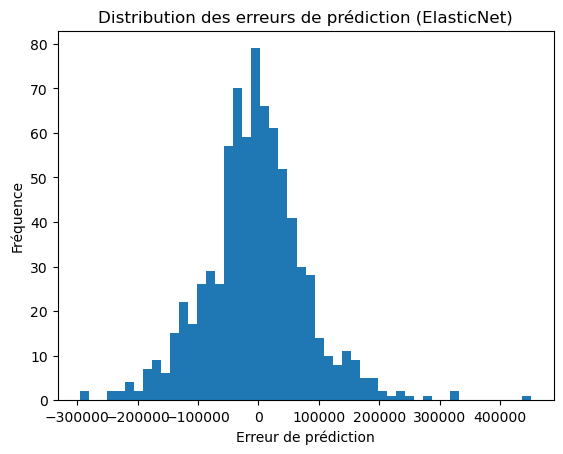

In [157]:
plt.hist(errors, bins=50)
plt.xlabel('Erreur de prédiction')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction (ElasticNet)')
plt.show()

# Logarithmie

In [160]:
df_house = pd.read_csv("HousePrice_Tls_2023.csv")

In [163]:
df_house['log_valeur_fonciere'] = np.log1p(df_house['valeur_fonciere'])

In [165]:
df_house

,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,log_valeur_fonciere
0,236250.0,31160,Couret,Maison,121.0,4.0,sols,745.0,12.372650
1,132000.0,31160,Couret,Maison,46.0,2.0,terrains d'agrément,1149.0,11.790565
2,60000.0,31160,Couret,Maison,106.0,3.0,sols,350.0,11.002117
3,190000.0,31160,Couret,Maison,112.0,4.0,sols,565.0,12.154785
4,235000.0,31470,Saiguède,Maison,85.0,3.0,sols,600.0,12.367345
...,...,...,...,...,...,...,...,...,...
8479,58000.0,31440,Argut-Dessous,Maison,48.0,1.0,sols,90.0,10.968216
8480,190000.0,31440,Argut-Dessous,Maison,84.0,4.0,prés,830.0,12.154785
8481,80000.0,31440,Argut-Dessous,Maison,78.0,3.0,sols,275.0,11.289794
8482,179800.0,31440,Bezins-Garraux,Maison,115.0,4.0,sols,539.0,12.099606


In [172]:
df_house['code_postal'] = df_house['code_postal'].apply(str)

In [174]:
df_ml = df_house[['code_postal','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain','log_valeur_fonciere']]

In [176]:
my_object_df = df_ml.select_dtypes(include='object')

In [178]:
my_numeric_df = df_ml.select_dtypes(exclude='object')

In [181]:
df_objects_dummies = pd.get_dummies(my_object_df,drop_first=True)
df_objects_dummies

,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,code_postal_31160,code_postal_31170,code_postal_31180,code_postal_31190,...,code_postal_31880,nature_culture_landes,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8479,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8480,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8481,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8482,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [184]:
final_df= pd.concat([my_numeric_df,df_objects_dummies],axis=1)
final_df

,surface_reelle_bati,nombre_pieces_principales,surface_terrain,log_valeur_fonciere,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,code_postal_31880,nature_culture_landes,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vignes
0,121.0,4.0,745.0,12.372650,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,46.0,2.0,1149.0,11.790565,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,106.0,3.0,350.0,11.002117,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,112.0,4.0,565.0,12.154785,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,85.0,3.0,600.0,12.367345,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8479,48.0,1.0,90.0,10.968216,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8480,84.0,4.0,830.0,12.154785,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8481,78.0,3.0,275.0,11.289794,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
8482,115.0,4.0,539.0,12.099606,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [186]:
final_df.to_csv('HousePricefinal_2023_log_ML.csv',index=False)

In [ ]:
X= df.drop('log_valeur_fonciere',axis=1)
y=df['log_valeur_fonciere']